In [64]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [65]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)
#f_names = wnv_train.columns[2:]

In [66]:
# convert list of labels to binary class matrix
labels = wnv_train.WnvPresent.values.astype('int')
yr_train = labels
wnv_train.drop('WnvPresent', axis=1, inplace=True)
f_names = wnv_train.columns

In [67]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.values).astype('float64')
Xr_test = (wnv_test.values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train)

In [68]:
# parameters
n_neighbors = 30
n_components = 65
n_estimators = 1000
n_jobs = 3
p_level = 0.3

In [69]:
#clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf = ExtraTreesClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
#clf.fit(X_train, y_train)
clf.fit(Xn_train, yr_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
proba = clf.predict_proba(X_test)
expected = y_test

In [70]:
# accuracy
matches = (predicted == expected)
print matches.sum() / float(len(matches))

# f1 score

print classification_report(expected, predicted)

# confusion matrix
print confusion_matrix(expected, predicted)

# auc
print roc_auc_score(expected, proba[:,1])

0.980966882375
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2495
          1       0.96      0.65      0.77       132

avg / total       0.98      0.98      0.98      2627

[[2491    4]
 [  46   86]]
0.994118540111


Area under the ROC curve : 0.994119


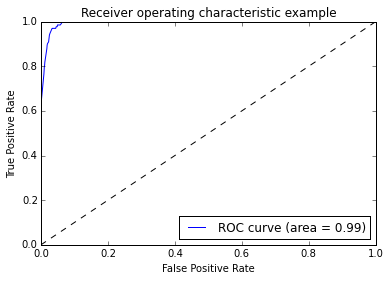

In [71]:
#print np.count_nonzero(predicted == 1)
#print np.count_nonzero(y_test)
#np.max(proba[:,1])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(expected, proba[:,1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [72]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(f_names)):
    print("%d. %s (%f)" % (f + 1, f_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Longitude (0.249141)
2. Trap (0.236230)
3. Latitude (0.232140)
4. AddressAccuracy (0.076108)
5. CULEX PIPIENS/RESTUANS (0.023671)
6. CULEX PIPIENS (0.023149)
7. CULEX RESTUANS (0.013754)
8. Dawn (0.010106)
9. Sunrise (0.009722)
10. Dusk (0.009337)
11. Sunset (0.008974)
12. DayOfYear (0.008873)
13. Noon (0.005173)
14. MoonPhase (0.004883)
15. DayOfMonth (0.003868)
16. DewPoint_1 (0.003769)
17. Cool_1 (0.003653)
18. DewPoint_2 (0.003652)
19. DayOfWeek (0.003521)
20. Tavg_1 (0.003517)
21. ResultSpeed_2 (0.003499)
22. Cool_2 (0.003449)
23. ResultDir_2 (0.003404)
24. ResultSpeed_1 (0.003390)
25. Tmax_1 (0.003227)
26. WetBulb_1 (0.003166)
27. AvgSpeed_2 (0.003160)
28. Tmax_2 (0.003129)
29. AvgSpeed_1 (0.003111)
30. PrecipTotal_2 (0.003096)
31. Tmin_2 (0.003096)
32. Tavg_2 (0.003087)
33. Tmin_1 (0.003056)
34. ResultDir_1 (0.003034)
35. WetBulb_2 (0.002968)
36. Depart_1 (0.002915)
37. SeaLevel_2 (0.002679)
38. StnPressure_2 (0.002575)
39. SeaLevel_1 (0.002501)
40. StnPressu

In [73]:
proba = clf.predict_proba(Xn_test)
print np.max(proba[:,1])

0.598


In [74]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba[:,1], "../working/sklearn_test_" + st + ".csv")